# Composing Scalable Nonlinear Algebraic Solvers

Consider,

$$
\mathbf{F} (\mathbf{x}) = \mathbf{b}
$$

Then the residual is defined as

$$
\mathbf{r} (\mathbf{x}) = \mathbf{F} (\mathbf{x}) - \mathbf{b}
$$

The linear system 

$$
\mathbf{A} \mathbf{x} = \mathbf{b}
$$

with residual 

$$
\mathbf{r} (\mathbf{x}) = \mathbf{A} \mathbf{x} - \mathbf{b}
$$

is an important special case that we will use. 

Traditional stationary solvers are given by

$$
\mathbf{x}_{i+1} = \mathbf{x}_{i} - \mathbf{P}^{-1} (\mathbf{A} \mathbf{x}_{i} - \mathbf{b})
$$

with $\mathbf{P}^{-1}$ being a linear operator. The Jacobi, Gauss-Seidel and multigrid iterations are examples of linar stationary solvers.

## Linear problems
Composition of linear precoditionrs is given by

$$
\mathbf{x}_{i+1} = \mathbf{x}_{i} - (\alpha_P \mathbf{P}^{-1} + \alpha_Q \mathbf{Q}^{-1}) (\mathbf{A} \mathbf{x}_{i} - \mathbf{b})
$$

this is the additive approach. The multiplicative approach is given by,

$$
\begin{align}
\mathbf{x}_{i+1/2} &= \mathbf{x}_{i} - \mathbf{P}^{-1} (\mathbf{A} \mathbf{x}_{i} - \mathbf{b})\\
\mathbf{x}_{i+1} &= \mathbf{x}_{i+1/2}-\mathbf{Q}^{-1} (\mathbf{A} \mathbf{x}_{i} - \mathbf{b})
\end{align}
$$


## Nonlinear problems


### Additive

$$
\mathbf{x}_{i+1} = \mathbf{x}_{i}
   + \alpha_M ( \mathbf{M}(\mathbf{F}, \mathbf{x_i}, \mathbf{b}) - \mathbf{x}_i ) 
   + \alpha_N ( \mathbf{N}(\mathbf{F}, \mathbf{x_i}, \mathbf{b}) - \mathbf{x}_i ) 
$$


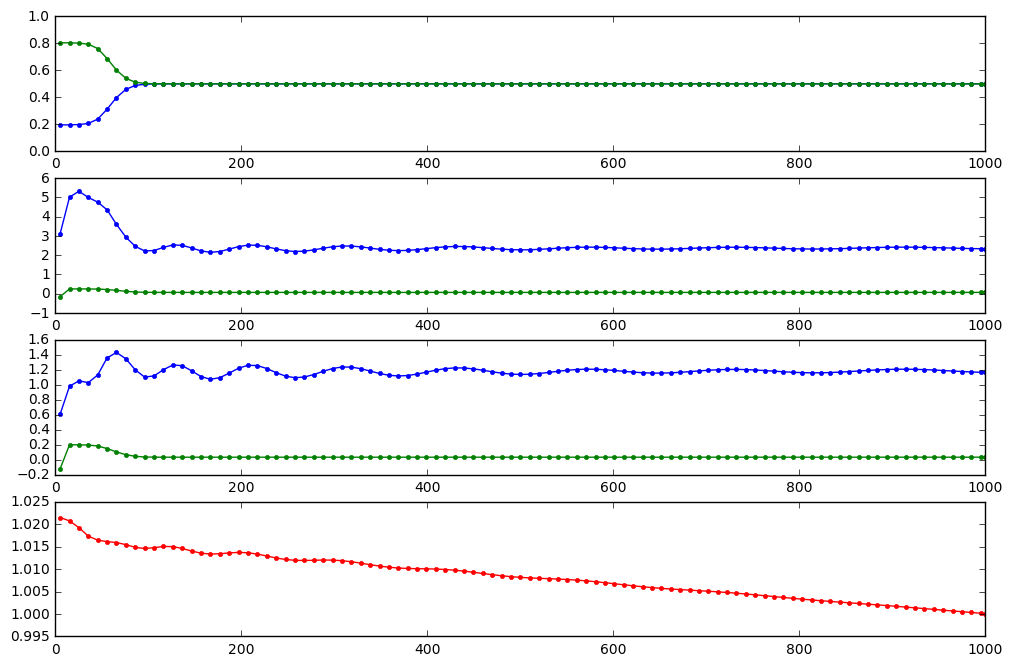

In [3]:
import sys
import numpy as np
import petsc4py
from petsc4py import PETSc
from matplotlib import pyplot as plt
from flow import transient_pipe_flow_1D

petsc4py.init(sys.argv)
options = PETSc.Options()
options.clear()

dt = 1     # [s]
dt_min = 1 # [s]
dt_max = 10.0  # [s]

# TS config
options.setValue('-ts_type', 'theta') # https://en.wikipedia.org/wiki/Backward_differentiation_formula
options.setValue('-ts_adapt_type', 'basic') # basic or none
options.setValue('-ts_theta_adapt', None)
options.setValue('-ts_rtol', 0.0001)
options.setValue('-ts_atol', 0.0001)
options.setValue('-ts_adapt_dt_min', dt_min)
options.setValue('-ts_adapt_dt_max', dt_max)
options.setValue('-ts_exact_final_time', 'matchstep') # http://www.mcs.anl.gov/petsc/petsc-current/docs/manualpages/TS/TSSetExactFinalTime.html
options.setValue('-ts_adapt_scale_solve_failed', 0.5) # Scale step by this factor if solve fails ()
options.setValue('-ts_adapt_basic_clip', (0.1, 10.0)) # Admissible decrease/increase factor in step size (TSAdaptBasicSetClip)
options.setValue('-ts_adapt_basic_safety', 0.9) # Safety factor relative to target error ()
options.setValue('-ts_adapt_basic_reject_safety', 0.5) # Extra safety factor to apply if the last step was rejected ()
# options.setValue('-ts_adapt_basic_always_accept', None) # Always accept the step regardless of whether local truncation error meets goal ()
# options.setValue('-ts_error_if_step_fails', False) # Always accept the step regardless of whether local truncation error meets goal ()
options.setValue('-ts_max_steps', 10000000)
options.setValue('-ts_monitor', None)
# options.setValue('-ts_adjoint_solve', True)


dense = False
if dense:
    options.setValue('-dmcomposite_dense_jacobian', None)
else:
    options.delValue('-dmcomposite_dense_jacobian')

options.setValue('-ts_fd_color', None)

options.setValue('-mat_fd_type', 'ds')
# options.setValue('-mat_fd_coloring_err', 1e-2)
# options.setValue('-mat_fd_coloring_umin', 1e-3)


# options.setValue('-ts_max_snes_failures', 1)
# options.setValue('-ts_max_reject', 10)

# options.setValue('-mat_view', 'draw')
# options.setValue('-draw_pause', 5000)
#options.setValue('-is_coloring_view', '')
# options.setValue('-help', None)

options.setValue('-snes_monitor_short', None)
options.setValue('-snes_converged_reason', None)

# options.setValue('-snes_convergence_test', 'skip')
# options.setValue('-snes_max_it', 10)

options.setValue('-snes_stol', 1e-8)
options.setValue('-snes_rtol', 1e-8)
options.setValue('-snes_atol', 1e-8)
#options.setValue('-snes_type', 'newtonls')
#options.setValue('-snes_linesearch_type', 'basic')
#options.setValue('-npc_snes_type', 'ngs')
# options.setValue('-npc_snes_type', 'fas')


# newtonls newtontr test nrichardson ksponly vinewtonrsls 
# vinewtonssls ngmres qn shell ngs ncg fas ms nasm anderson 
# aspin composite python (SNESSetType)

options.setValue('-snes_type', 'composite')
options.setValue('-snes_composite_type', 'additiveoptimal')
options.setValue('-snes_composite_sneses', 'nrichardson,newtonls')
#options.setValue('-snes_composite_sneses', 'fas,newtonls')
# options.setValue('-snes_composite_sneses', 'ngmres,newtonls')
     

time_intervals = [100] # [s]

npipes = 1
nx = 100

nphases = 2
dof = nphases * 2 + 1

pipe_length = 1000.0 # [m]



initial_solution = np.zeros((nx,dof))
initial_solution[:,0:nphases] = 0.0001 # Velocity

αG = 0.5
initial_solution[:,2] = αG # vol frac
initial_solution[:,3] = 1-αG # vol frac
initial_solution[:,-1] = 1.0  # Pressure
initial_time = 0.0

sols = []
for i, final_time in enumerate(time_intervals):

    sol, final_dt = transient_pipe_flow_1D(
        npipes, nx, dof, nphases,
        pipe_length,
        initial_time,
        final_time,
        dt,
        dt_min,
        dt_max,
        initial_solution.flatten(),
        impl_python=True
        )
    
    SOL = sol[...].reshape(nx, dof)

    U = SOL[:, 0:nphases]
    α = SOL[:, nphases:-1]
    P = SOL[:, -1]
    
    initial_solution[:,0:nphases] = U # Velocity
    initial_solution[:,nphases:-1] = α # vol frac
    initial_solution[:,-1] = P   # Pressure

    initial_time = final_time
    dt = final_dt
             
    sols.append((U, P))
    
    dx = pipe_length / (nx - 1)
    x = np.linspace(0, npipes*pipe_length, npipes*nx, endpoint=True) + 0.5*dx
    xx = np.concatenate((x[:-1], [pipe_length]))


UU = U
PP = np.concatenate((P[:-1], [1.0]))
αα = α
f, axarr = plt.subplots(4, sharex=True, figsize=(12,8))
axarr[0].set_title('Results')
axarr[0].cla()
axarr[1].cla()
axarr[2].cla()
axarr[3].cla()
axarr[0].plot(xx, αα, '.-')
axarr[1].plot(xx, UU, '.-')
axarr[2].plot(xx, αα*UU, '.-')
axarr[3].plot(xx, PP, 'r.-')
plt.xlim(0, pipe_length)
axarr[0].set_ylim(0, 1)
plt.show()